In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils
from pyCascade.probeReadWrite import read_probes_file_switch
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd
import seaborn as sns
from fnmatch import fnmatch
from cycler import cycler
import plotly.express as px
import plotly
import re

plt.rcParams['figure.dpi'] = 140
im_scaling = .75
plt.rcParams['figure.figsize'] = [6.4 * im_scaling, 4.8 * im_scaling]

category =  "config2"

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')

Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd'

In [2]:
run = 52
probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'
oak_probes_dir =  f'{home_dir}/CHARLES/{category}/R{run}/probes/probesOut_parquet/'

In [3]:
qoisOutputed = ["comp(u,0)", "comp(u,1)", "comp(u,2)", "p", "T", "D", "S"]
probesV = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, probe_type = "VOLUMETRIC_PROBES", flux_quants = qoisOutputed, file_type = "csv", name_pattern="room")

In [4]:
start = 1000 #120000# 30000
stop = -1000 #70000 #160000
by = 1

steps = probesV.probe_steps[start:stop:by]
times = probesV.probe_times.iloc[start:stop:by]
names = [name for name in  probesV.probe_names if "_h_0--1" in name]
qois = ['D', 'T', 'S']

In [5]:
df = probesV.statistics(
    names = names, 
    steps = steps,
    quants = qois,
    parrallel=True,
    # processing = [exponential_fit]
    )

processing data took 119 seconds


In [6]:
# Define the fitting function
def exponential_fit(y, time = times, c = None):
        # Convert input to numpy arrays if they are pandas Series
        time = time.copy()
        y = y.copy()
        if hasattr(y, 'values'):
                y = y.values
        if hasattr(time, 'values'):
                time = time.values
        if y[0] == 0:
                return 0
        time -= time[0]
        y += 1e-6
        y /= y[0]
        if c == None:
                exp_decay = lambda x, a, c: (1 - c) * np.exp(-x/a) + c #define theoretical exponential decay function
                popt, _ = sp.optimize.curve_fit(exp_decay, time, y, p0=[100, 0], bounds=([0, 0], [np.inf, 1]))
        else:
                exp_decay = lambda x, a: (1 - c) * np.exp(-x/a) + c #define theoretical exponential decay function
                popt, _ = sp.optimize.curve_fit(exp_decay, time, y, p0=100, bounds=(0, np.inf))
                popt = np.append(popt, c)
        return popt

taus = pd.DataFrame()
taus['D'] = df['D'].map(lambda y: exponential_fit(y, c = 0))
taus['T'] = df['T'].map(exponential_fit)
# taus['S'] = df['S'].map(exponential_fit)

In [7]:
# # Define the fitting function
# def exponential_fit(y, time = times):
#     # Convert input to numpy arrays if they are pandas Series
#     if hasattr(y, 'values'):
#         y = y.values
#     if hasattr(time, 'values'):
#         time = time.values

#     time -= time[0]
    
#     # Avoid log(0) by adding a small constant
#     log_y = np.log(y + 1e-6)
    
#     # Fit a line through the origin using least squares
#     slope, residuals, rank, singular_values = np.linalg.lstsq(time[:, np.newaxis], log_y, rcond=None)
    
#     # Ensure slope is correctly unpacked
#     slope = slope[0]
    
#     # Calculate the characteristic time (assuming y = a * exp(b * time), then b = slope)
#     return -1/slope

In [8]:
taus

,D,T
room0_0-0_h_0--1,0,0
room0_0-0_h_0--1_Bx,0,0
room0_0-0_h_0--1_Bxz,0,0
room0_0-0_h_0--1_Bz,0,0
room0_0-1_h_0--1,0,0
...,...,...
room5_2-0_h_0--1_Bz,0,0
room5_2-1_h_0--1,0,0
room5_2-1_h_0--1_Bx,0,0
room5_2-1_h_0--1_Bxz,0,0


room0_0-0_h_0--1          [Line2D(_child0)]
room0_0-0_h_0--1_Bx       [Line2D(_child1)]
room0_0-0_h_0--1_Bxz      [Line2D(_child2)]
room0_0-0_h_0--1_Bz       [Line2D(_child3)]
room0_0-1_h_0--1          [Line2D(_child4)]
                               ...         
room5_2-0_h_0--1_Bz     [Line2D(_child139)]
room5_2-1_h_0--1        [Line2D(_child140)]
room5_2-1_h_0--1_Bx     [Line2D(_child141)]
room5_2-1_h_0--1_Bxz    [Line2D(_child142)]
room5_2-1_h_0--1_Bz     [Line2D(_child143)]
Name: S, Length: 144, dtype: object

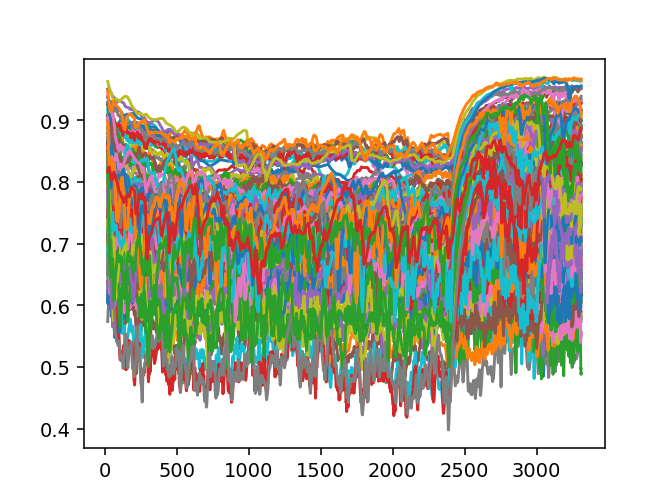

In [13]:
exp_decay = lambda p, x: (1 - p[1]) * np.exp(-x/p[0]) + p[1]
mapExpPlot = lambda y, x = times: plt.plot(x, y/y.iloc[0])
mapPlot = lambda y, x = times: plt.plot(x, y)
mapPlotExpDecay = lambda p, x = times: plt.plot(x, exp_decay(p, x - x.iloc[0]))
plt.figure()
df['S'].map(mapPlot)
# df.map(mapPlot)
# taus.map(mapPlotExpDecay)

In [10]:
def sum_columns_by_room(df):
    # Dictionary to hold the grouped column names
    grouped_volumes = {}

    # Loop over each column in the DataFrame
    for row, v in df.iterrows():
        room_code = row.split('_')[1]
        if room_code == "0-1": # dual room
            room_code = "1-1"
        elif room_code == "2-1":
            room_code = "2-0"
        # Extract the base name by removing the room number
        base_name = re.sub(r'room\d+_\d-\d', f'room_{room_code}', row)
        if base_name not in grouped_volumes:
            grouped_volumes[base_name] = []
        grouped_volumes[base_name].append(row)
    
    # Sum the rows based on the grouped row names
    summed_df = {}
    for base_name, rows in grouped_volumes.items():
        dfCombined = df.loc[rows].apply(sum) / len(rows)
        summed_df[base_name] = {}
        for col, s in dfCombined.items():
            summed_df[base_name][col] = s

    return pd.DataFrame(summed_df).T
    

df_rooms =  sum_columns_by_room(df)
taus_rooms['D'] = df_rooms['D'].map(lambda y: exponential_fit(y, c = 0))
taus_rooms['T'] = df_rooms['T'].map(exponential_fit)

plt.figure()
df_rooms.map(mapPlot)
taus_rooms.map(mapPlotExpDecay)

    # plt.legend()

NameError: name 'taus_rooms' is not defined